# Medicare Part D AI Forecasting Tool

In [1]:
!pip install optuna

In [2]:
# Import Necessary Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import lightgbm as lgb
import shap
import joblib
import optuna
from optuna import Trial
from optuna.visualization import plot_optimization_history
import os
import warnings
warnings.filterwarnings('ignore')


In [3]:
#  Upload data file
from google.colab import files
uploaded = files.upload()

Saving DSD_PTD_RY25_P04_V10_DY23_BGM.csv to DSD_PTD_RY25_P04_V10_DY23_BGM.csv


In [4]:
# Replace with the correct file name
file_name = list(uploaded.keys())[0]

if file_name.endswith('.csv'):
    df = pd.read_csv(file_name)
elif file_name.endswith(('.xls', '.xlsx')):
    df = pd.read_excel(file_name)
else:
    raise ValueError("Unsupported file type.")

# Basic exploration

In [5]:
# Basic exploration
print("✅ Data Loaded Successfully")


✅ Data Loaded Successfully


In [6]:
print(f"🔍 Shape: {df.shape}")


🔍 Shape: (14309, 46)


In [7]:
print("\n📌 Columns:")
for col in df.columns:
    print(f"- {col}")



📌 Columns:
- Brnd_Name
- Gnrc_Name
- Tot_Mftr
- Mftr_Name
- Tot_Spndng_2019
- Tot_Dsg_Unts_2019
- Tot_Clms_2019
- Tot_Benes_2019
- Avg_Spnd_Per_Dsg_Unt_Wghtd_2019
- Avg_Spnd_Per_Clm_2019
- Avg_Spnd_Per_Bene_2019
- Outlier_Flag_2019
- Tot_Spndng_2020
- Tot_Dsg_Unts_2020
- Tot_Clms_2020
- Tot_Benes_2020
- Avg_Spnd_Per_Dsg_Unt_Wghtd_2020
- Avg_Spnd_Per_Clm_2020
- Avg_Spnd_Per_Bene_2020
- Outlier_Flag_2020
- Tot_Spndng_2021
- Tot_Dsg_Unts_2021
- Tot_Clms_2021
- Tot_Benes_2021
- Avg_Spnd_Per_Dsg_Unt_Wghtd_2021
- Avg_Spnd_Per_Clm_2021
- Avg_Spnd_Per_Bene_2021
- Outlier_Flag_2021
- Tot_Spndng_2022
- Tot_Dsg_Unts_2022
- Tot_Clms_2022
- Tot_Benes_2022
- Avg_Spnd_Per_Dsg_Unt_Wghtd_2022
- Avg_Spnd_Per_Clm_2022
- Avg_Spnd_Per_Bene_2022
- Outlier_Flag_2022
- Tot_Spndng_2023
- Tot_Dsg_Unts_2023
- Tot_Clms_2023
- Tot_Benes_2023
- Avg_Spnd_Per_Dsg_Unt_Wghtd_2023
- Avg_Spnd_Per_Clm_2023
- Avg_Spnd_Per_Bene_2023
- Outlier_Flag_2023
- Chg_Avg_Spnd_Per_Dsg_Unt_22_23
- CAGR_Avg_Spnd_Per_Dsg_Unt_19_23


In [8]:
print(f"\n🧼 Missing values:\n{df.isnull().sum()}")


🧼 Missing values:
Brnd_Name                             0
Gnrc_Name                             0
Tot_Mftr                              0
Mftr_Name                             0
Tot_Spndng_2019                    4205
Tot_Dsg_Unts_2019                  4205
Tot_Clms_2019                      4205
Tot_Benes_2019                     4292
Avg_Spnd_Per_Dsg_Unt_Wghtd_2019    4205
Avg_Spnd_Per_Clm_2019              4205
Avg_Spnd_Per_Bene_2019             4399
Outlier_Flag_2019                  4207
Tot_Spndng_2020                    3258
Tot_Dsg_Unts_2020                  3258
Tot_Clms_2020                      3258
Tot_Benes_2020                     3435
Avg_Spnd_Per_Dsg_Unt_Wghtd_2020    3258
Avg_Spnd_Per_Clm_2020              3258
Avg_Spnd_Per_Bene_2020             3518
Outlier_Flag_2020                  3262
Tot_Spndng_2021                    2278
Tot_Dsg_Unts_2021                  2278
Tot_Clms_2021                      2278
Tot_Benes_2021                     2590
Avg_Spnd_Per_Dsg_Unt_

In [9]:
print("\ Preview top rows:")
df.head()

\ Preview top rows:


,Brnd_Name,Gnrc_Name,Tot_Mftr,Mftr_Name,Tot_Spndng_2019,Tot_Dsg_Unts_2019,Tot_Clms_2019,Tot_Benes_2019,Avg_Spnd_Per_Dsg_Unt_Wghtd_2019,Avg_Spnd_Per_Clm_2019,...,Tot_Spndng_2023,Tot_Dsg_Unts_2023,Tot_Clms_2023,Tot_Benes_2023,Avg_Spnd_Per_Dsg_Unt_Wghtd_2023,Avg_Spnd_Per_Clm_2023,Avg_Spnd_Per_Bene_2023,Outlier_Flag_2023,Chg_Avg_Spnd_Per_Dsg_Unt_22_23,CAGR_Avg_Spnd_Per_Dsg_Unt_19_23
0,1st Tier Unifine Pentips,"Pen Needle, Diabetic",1,Overall,139201.68,642471.0,5392.0,1878.0,0.216788,25.816335,...,44355.04,195672.0,1613,699.0,0.227162,27.498475,63.454993,0.0,0.005702,0.011754
1,1st Tier Unifine Pentips,"Pen Needle, Diabetic",1,Owen Mumford Us,139201.68,642471.0,5392.0,1878.0,0.216788,25.816335,...,44355.04,195672.0,1613,699.0,0.227162,27.498475,63.454993,0.0,0.005702,0.011754
2,1st Tier Unifine Pentips Plus,"Pen Needle, Diabetic",1,Overall,343031.42,1830596.0,14581.0,5319.0,0.187389,23.525919,...,97951.18,406617.0,3269,1267.0,0.240932,29.963652,77.309534,0.0,0.022165,0.064848
3,1st Tier Unifine Pentips Plus,"Pen Needle, Diabetic",1,Owen Mumford Us,343031.42,1830596.0,14581.0,5319.0,0.187389,23.525919,...,97951.18,406617.0,3269,1267.0,0.240932,29.963652,77.309534,0.0,0.022165,0.064848
4,Abacavir,Abacavir Sulfate,5,Overall,10110328.45,3316293.0,42629.0,6085.0,3.482725,237.170200,...,5287295.41,1648593.0,19632,2809.0,3.594357,269.320263,1882.269637,0.0,-0.071481,0.007919


In [10]:
# Show detailed structure of the data
print("📄 Dataset Info:\n")
df.info()

📄 Dataset Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14309 entries, 0 to 14308
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Brnd_Name                        14309 non-null  object 
 1   Gnrc_Name                        14309 non-null  object 
 2   Tot_Mftr                         14309 non-null  int64  
 3   Mftr_Name                        14309 non-null  object 
 4   Tot_Spndng_2019                  10104 non-null  float64
 5   Tot_Dsg_Unts_2019                10104 non-null  float64
 6   Tot_Clms_2019                    10104 non-null  float64
 7   Tot_Benes_2019                   10017 non-null  float64
 8   Avg_Spnd_Per_Dsg_Unt_Wghtd_2019  10104 non-null  float64
 9   Avg_Spnd_Per_Clm_2019            10104 non-null  float64
 10  Avg_Spnd_Per_Bene_2019           9910 non-null   float64
 11  Outlier_Flag_2019                10102 non-null  float64
 12  T

What have Discovered So Far

- Loaded the Medicare Part D Spending by Drug dataset with 14,309 rows and 46 columns.

- The dataset includes drug-level cost, usage, and spending metrics from 2019 to 2023.

- Column names follow a clear time-based pattern (e.g., Tot_Spndng_2021, Outlier_Flag_2022).

- Some fields like brand name, generic name, and manufacturer are non-null and reliable anchors for grouping.

- Missing values increase as we go back in time, especially in 2019 and 2020.

- 2023 data is most complete, while older years show partial coverage likely due to drugs entering or exiting the market.

- will avoid dropping rows unnecessarily and instead focus on selective dropping and proper imputation.

**Handling Missing Values**

In [11]:
# Count total rows
total_rows = df.shape[0]

In [12]:
#  See null percentages
null_percent = df.isnull().sum() / total_rows * 100
print("🔍 Percentage of missing data per column:\n")
print(null_percent[null_percent > 0].sort_values(ascending=False))

🔍 Percentage of missing data per column:

Avg_Spnd_Per_Bene_2019             30.742889
Tot_Benes_2019                     29.995108
Outlier_Flag_2019                  29.401076
Tot_Spndng_2019                    29.387099
Tot_Dsg_Unts_2019                  29.387099
Avg_Spnd_Per_Dsg_Unt_Wghtd_2019    29.387099
Tot_Clms_2019                      29.387099
Avg_Spnd_Per_Clm_2019              29.387099
Avg_Spnd_Per_Bene_2020             24.585925
Tot_Benes_2020                     24.005870
Outlier_Flag_2020                  22.796841
Tot_Spndng_2020                    22.768887
Tot_Dsg_Unts_2020                  22.768887
Avg_Spnd_Per_Dsg_Unt_Wghtd_2020    22.768887
Tot_Clms_2020                      22.768887
Avg_Spnd_Per_Clm_2020              22.768887
Avg_Spnd_Per_Bene_2021             18.254246
Tot_Benes_2021                     18.100496
Outlier_Flag_2021                  15.948005
Tot_Spndng_2021                    15.920050
Tot_Dsg_Unts_2021                  15.920050
Avg_Spnd_Per_

In [13]:
#  Drop columns with >50% missing data
threshold = 50
cols_to_drop = null_percent[null_percent > threshold].index.tolist()
print(f"\n🧹 Dropping columns with >{threshold}% missing values:\n{cols_to_drop}")

df_cleaned = df.drop(columns=cols_to_drop)



🧹 Dropping columns with >50% missing values:
[]


In [14]:
# Impute numerical missing values (median by year if possible)
numeric_cols = df_cleaned.select_dtypes(include=['float64', 'int64']).columns.tolist()

for col in numeric_cols:
    if df_cleaned[col].isnull().sum() > 0:
        median_val = df_cleaned[col].median()
        df_cleaned[col].fillna(median_val, inplace=True)

print("\n✅ Missing values handled. Cleaned shape:", df_cleaned.shape)


✅ Missing values handled. Cleaned shape: (14309, 46)


In [15]:
# ✅ Confirm no missing values remain
print("\n📋 Final Missing Value Check (per column):\n")
missing_check = df_cleaned.isnull().sum()
for col, count in missing_check.items():
    print(f"{col}: {count}")



📋 Final Missing Value Check (per column):

Brnd_Name: 0
Gnrc_Name: 0
Tot_Mftr: 0
Mftr_Name: 0
Tot_Spndng_2019: 0
Tot_Dsg_Unts_2019: 0
Tot_Clms_2019: 0
Tot_Benes_2019: 0
Avg_Spnd_Per_Dsg_Unt_Wghtd_2019: 0
Avg_Spnd_Per_Clm_2019: 0
Avg_Spnd_Per_Bene_2019: 0
Outlier_Flag_2019: 0
Tot_Spndng_2020: 0
Tot_Dsg_Unts_2020: 0
Tot_Clms_2020: 0
Tot_Benes_2020: 0
Avg_Spnd_Per_Dsg_Unt_Wghtd_2020: 0
Avg_Spnd_Per_Clm_2020: 0
Avg_Spnd_Per_Bene_2020: 0
Outlier_Flag_2020: 0
Tot_Spndng_2021: 0
Tot_Dsg_Unts_2021: 0
Tot_Clms_2021: 0
Tot_Benes_2021: 0
Avg_Spnd_Per_Dsg_Unt_Wghtd_2021: 0
Avg_Spnd_Per_Clm_2021: 0
Avg_Spnd_Per_Bene_2021: 0
Outlier_Flag_2021: 0
Tot_Spndng_2022: 0
Tot_Dsg_Unts_2022: 0
Tot_Clms_2022: 0
Tot_Benes_2022: 0
Avg_Spnd_Per_Dsg_Unt_Wghtd_2022: 0
Avg_Spnd_Per_Clm_2022: 0
Avg_Spnd_Per_Bene_2022: 0
Outlier_Flag_2022: 0
Tot_Spndng_2023: 0
Tot_Dsg_Unts_2023: 0
Tot_Clms_2023: 0
Tot_Benes_2023: 0
Avg_Spnd_Per_Dsg_Unt_Wghtd_2023: 0
Avg_Spnd_Per_Clm_2023: 0
Avg_Spnd_Per_Bene_2023: 0
Outlier_Flag_202

In [16]:
# Drop Duplicate Rows
print("🔎 Before deduplication:", df_cleaned.shape)
df_cleaned = df_cleaned.drop_duplicates()
print("✅ After deduplication:", df_cleaned.shape)

🔎 Before deduplication: (14309, 46)
✅ After deduplication: (14309, 46)


- No duplicate rows were found in dataset

In [17]:
# Clean Column Names (replace spaces, unify case)
df_cleaned.columns = df_cleaned.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('-', '_')


- Cleans and standardizes column names for easier coding and consistency

In [18]:
# Standardize Manufacturer Names
df_cleaned['mftr_name'] = df_cleaned['mftr_name'].str.strip().str.lower()
df_cleaned['mftr_name'] = df_cleaned['mftr_name'].str.replace(r'\s+', ' ', regex=True)


- Standardizes manufacturer names by trimming spaces, converting to lowercase, and removing extra whitespace.

In [19]:
# Reshape From Wide to Long Format
# Melt year-based metrics into long format
id_vars = ['brnd_name', 'gnrc_name', 'tot_mftr', 'mftr_name']
value_vars = [col for col in df_cleaned.columns if any(str(yr) in col for yr in range(2019, 2024))]

df_long = pd.wide_to_long(df_cleaned, stubnames=[
    'tot_spndng', 'tot_dsg_unts', 'tot_clms', 'tot_benes',
    'avg_spnd_per_dsg_unt_wghtd', 'avg_spnd_per_clm', 'avg_spnd_per_bene',
    'outlier_flag'
], i=['brnd_name', 'gnrc_name', 'mftr_name', 'tot_mftr'], j='year', sep='_', suffix='\d+').reset_index()

print("🎯 Long format shape:", df_long.shape)
df_long.head()


🎯 Long format shape: (71545, 15)


,brnd_name,gnrc_name,mftr_name,tot_mftr,year,cagr_avg_spnd_per_dsg_unt_19_23,chg_avg_spnd_per_dsg_unt_22_23,tot_spndng,tot_dsg_unts,tot_clms,tot_benes,avg_spnd_per_dsg_unt_wghtd,avg_spnd_per_clm,avg_spnd_per_bene,outlier_flag
0,1st Tier Unifine Pentips,"Pen Needle, Diabetic",overall,1,2019,0.011754,0.005702,139201.68,642471.0,5392.0,1878.0,0.216788,25.816335,74.122300,0.0
1,1st Tier Unifine Pentips,"Pen Needle, Diabetic",overall,1,2020,0.011754,0.005702,118923.24,547006.0,4457.0,1595.0,0.217701,26.682351,74.560025,0.0
2,1st Tier Unifine Pentips,"Pen Needle, Diabetic",overall,1,2021,0.011754,0.005702,102280.76,459384.0,3708.0,1313.0,0.223001,27.583808,77.898522,0.0
3,1st Tier Unifine Pentips,"Pen Needle, Diabetic",overall,1,2022,0.011754,0.005702,70039.61,310304.0,2501.0,1147.0,0.225874,28.004642,61.063304,0.0
4,1st Tier Unifine Pentips,"Pen Needle, Diabetic",overall,1,2023,0.011754,0.005702,44355.04,195672.0,1613.0,699.0,0.227162,27.498475,63.454993,0.0


- 🔄 Reshaped the dataset from wide to long format Transformed year-specific columns (e.g., tot_spndng_2019, tot_spndng_2020, ...) into a unified tot_spndng column with a corresponding year column.

- This structure simplifies groupby operations, visualizations, and time series modeling across years.

In [20]:
# Show detailed structure of the reshaped DataFrame
print("📄 Dataset Info:\n")
df_long.info()

📄 Dataset Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71545 entries, 0 to 71544
Data columns (total 15 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   brnd_name                        71545 non-null  object 
 1   gnrc_name                        71545 non-null  object 
 2   mftr_name                        71545 non-null  object 
 3   tot_mftr                         71545 non-null  int64  
 4   year                             71545 non-null  int64  
 5   cagr_avg_spnd_per_dsg_unt_19_23  71545 non-null  float64
 6   chg_avg_spnd_per_dsg_unt_22_23   71545 non-null  float64
 7   tot_spndng                       71545 non-null  float64
 8   tot_dsg_unts                     71545 non-null  float64
 9   tot_clms                         71545 non-null  float64
 10  tot_benes                        71545 non-null  float64
 11  avg_spnd_per_dsg_unt_wghtd       71545 non-null  float64
 12  a

# Exploratory Data Analysis (EDA)

In [21]:
# Descriptive Statistics for Key Metrics
styled_stats = df_long[['tot_spndng', 'tot_dsg_unts', 'tot_clms', 'tot_benes',
                        'avg_spnd_per_dsg_unt_wghtd', 'avg_spnd_per_clm', 'avg_spnd_per_bene']].describe().style

# Apply styling
styled_stats = styled_stats.background_gradient(cmap='viridis') \
                             .set_caption("📊 Descriptive Statistics for Spending & Utilization Metrics") \
                             .format("{:,.2f}")

styled_stats


,tot_spndng,tot_dsg_unts,tot_clms,tot_benes,avg_spnd_per_dsg_unt_wghtd,avg_spnd_per_clm,avg_spnd_per_bene
count,"71,545.00","71,545.00","71,545.00","71,545.00","71,545.00","71,545.00","71,545.00"
mean,"31,127,616.98","16,165,986.89","212,526.41","67,416.13",193.97,"1,589.97","7,559.21"
std,"255,065,357.25","112,982,438.79","1,355,533.72","371,691.42","2,355.79","7,754.68","45,917.32"
min,26.43,0.70,11.00,11.00,0.00,0.04,0.10
25%,"131,892.14","32,209.00",689.00,333.00,0.61,37.83,97.95
50%,"1,312,670.35","306,657.00","5,864.00","2,065.50",2.05,110.62,283.23
75%,"5,814,277.28","1,773,856.00","30,748.00","10,487.00",9.99,422.13,"1,106.91"
max,"18,273,451,967.00","4,956,622,003.00","68,493,698.00","16,778,185.00","239,745.73","347,007.60","1,595,175.55"


- All variables have 71,545 records, indicating complete data across the metrics.

- Average total spending per record is about $31.1 million, but with a massive standard deviation, suggesting significant variance across entries.

- Drug units (tot_dsg_unts) and claims (tot_clms) show highly skewed distributions some records have extremely large values, as indicated by the max vs. median comparison.

- The average number of beneficiaries (tot_benes) per record is ~67,000, but again, some records reach up to 16.7 million, showing large-scale variance.

For calculated metrics:

-  Average spending per weighted dosage unit is 193.97,but it ranges up to $239,746, reflecting huge cost discrepancies.

- Spending per claim and spending per beneficiary also show heavy tails, with means much lower than the max values.

- Median values are much lower than means, reinforcing that distributions are right-skewed, likely due to a few extremely large observations.

Key Insights (Simplified above)

- Complete data: All variables have 71,545 entries solid data coverage.

- Total spending is very spread out, with huge differences across records.

- Dosage units and claims are highly skewed some values are abnormally high.

- Beneficiaries vary greatly, from a handful to over 16 million per record.

- Per-unit spending is usually low but spikes drastically in some cases.

- Spending per claim & beneficiary also shows extreme outliers.

- Means ≫ medians, confirming the presence of heavy right skew.


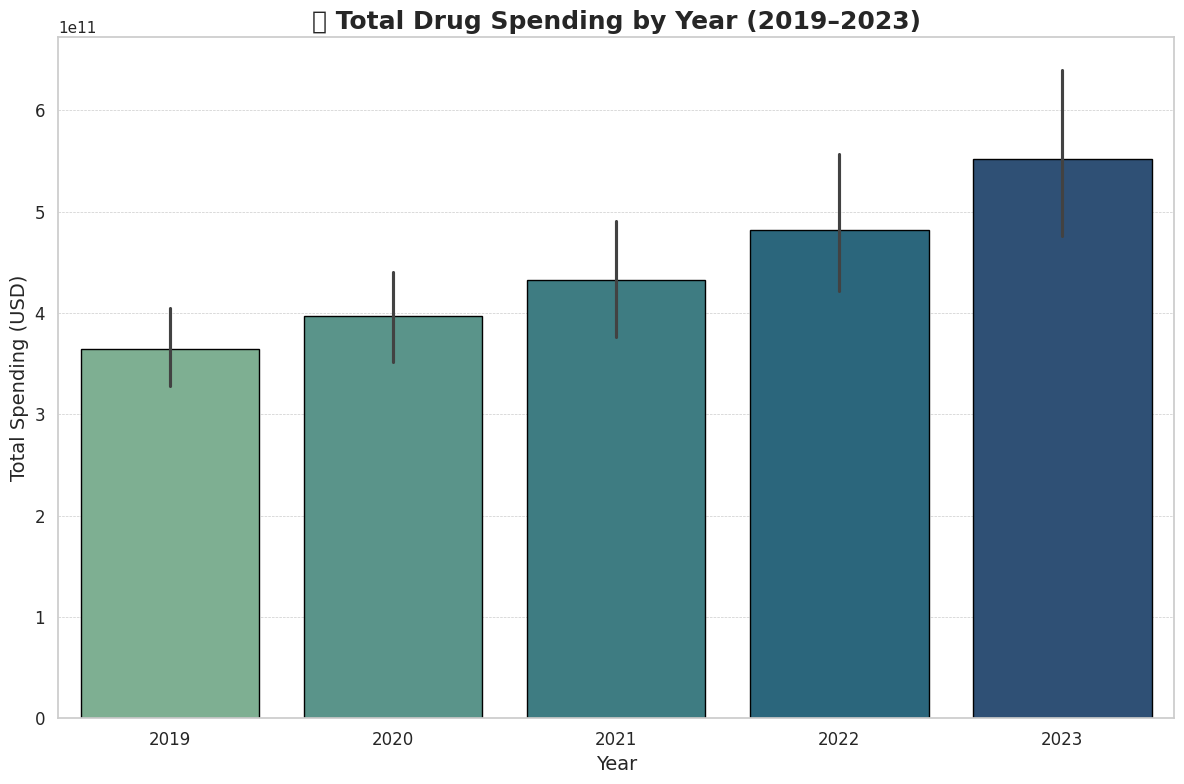

In [22]:
# Total Drug Spending Per Year
# Set the aesthetic style
sns.set(style='whitegrid')

plt.figure(figsize=(12, 8))
sns.barplot(
    data=df_long,
    x='year',
    y='tot_spndng',
    estimator='sum',
    palette='crest',  # Modern color palette
    edgecolor='black'
)

plt.title('💰 Total Drug Spending by Year (2019–2023)', fontsize=18, weight='bold')
plt.xlabel('Year', fontsize=14)
plt.ylabel('Total Spending (USD)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

🔍 What the Chart Shows (in simple words)

- The bar plot shows that total Medicare Part D drug spending increased every year from 2019 to 2023, with 2023 reaching the highest level.

- Each bar represents total national drug costs for that year. The rising bars suggest a steady upward trend in spending over time.

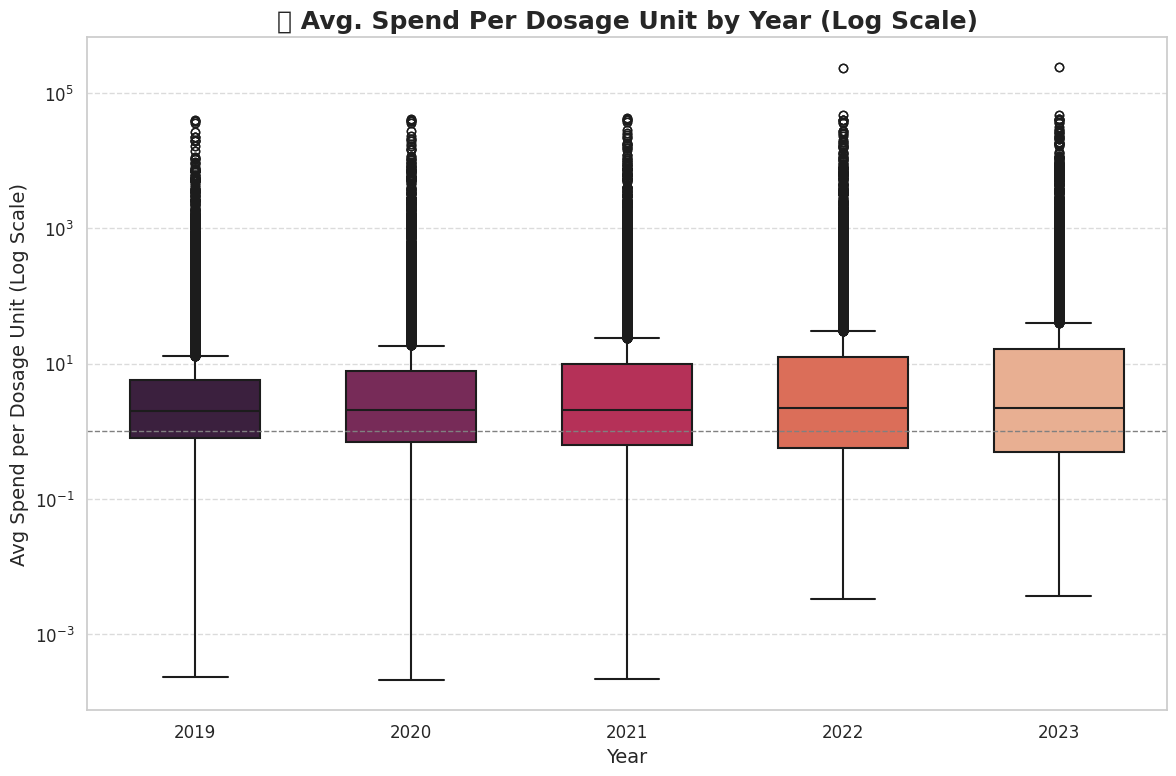

In [23]:
# Average Cost Per Dosage Unit Boxplot Across Years
# Set a clean and modern aesthetic
sns.set(style='whitegrid', palette='pastel', font_scale=1.2)

plt.figure(figsize=(12, 8))
box = sns.boxplot(
    data=df_long,
    x='year',
    y='avg_spnd_per_dsg_unt_wghtd',
    showfliers=True,  # Show outliers
    linewidth=1.5,
    width=0.6,
    palette='rocket'
)

# Customize appearance
plt.yscale('log')  # Helps reveal skewed distribution
plt.title('💊 Avg. Spend Per Dosage Unit by Year (Log Scale)', fontsize=18, weight='bold')
plt.xlabel('Year', fontsize=14)
plt.ylabel('Avg Spend per Dosage Unit (Log Scale)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Optional: Add horizontal reference line (e.g., mean or threshold)
plt.axhline(y=1, color='gray', linestyle='--', linewidth=1)

plt.tight_layout()
plt.show()

What the Boxplot Shows (Simple Terms)

This chart displays how the average spending per dosage unit changed from 2019 to 2023:

- Most drugs have a low cost per dose, clustered tightly in the lower part of each box.

- The box itself shows the middle 50% of values: from the 25th to 75th percentile (interquartile range), giving a sense of typical spending.

- The line inside the box marks the median the midpoint of all drug prices for that year.

- "Whiskers" extend to show variation outside the middle range, while dots beyond whiskers represent outliers the unusually expensive drugs.

- Every year, some drugs cost far more than others, and that gap grows in certain years.

- The log scale helps stretch the lower values and compress the extreme highs to better visualize patterns.

Together, this tells us that while most drugs are inexpensive per unit, a small number are exponentially more costly, and those outliers shift how Medicare resources are distributed.

In [24]:
# Add a simple summary to support above the plot
summary = df_long.groupby('year')['avg_spnd_per_dsg_unt_wghtd'].describe()[['count', 'mean', '50%', 'max']].rename(columns={'50%': 'median'})

# Apply color gradient higher values get deeper blue
styled_summary = summary.style.background_gradient(cmap='Blues').format('{:.2f}')
display(styled_summary)



,count,mean,median,max
year,,,,
2019,14309.00,125.13,1.97,40190.06
2020,14309.00,150.34,2.05,41142.93
2021,14309.00,169.87,2.07,42825.01
2022,14309.00,231.87,2.23,233364.03
2023,14309.00,292.65,2.24,239745.73


The summary table reinforces what the boxplot visually hinted

- Most drugs have very low average spending per unit (median ≈ $2 each year),

- But a few drugs cost tens or even hundreds of thousands per unit, which drives up the mean sharply over time (from 125 in 2019 to $293 in 2023),

- And the max values explode in 2022–2023, confirming the presence of extreme outliers seen in the boxplot whiskers.

So in short the table supports the boxplot by quantifying the outliers and skew it makes the chart’s story easier to understand with actual numbers.

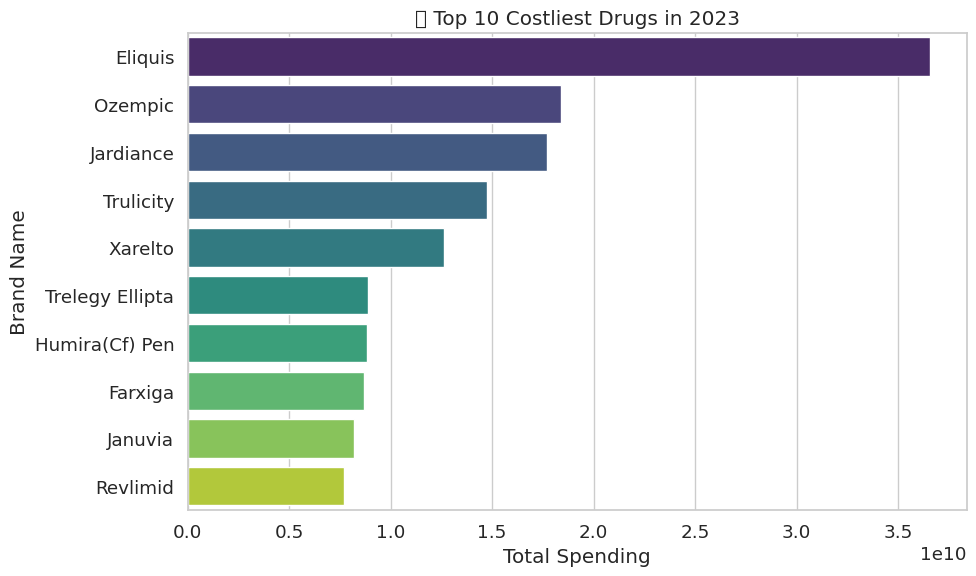

In [25]:
#  Top 10 Costliest Drugs in 2023
top2023 = df_long[df_long['year'] == 2023].groupby('brnd_name')['tot_spndng'].sum().nlargest(10).reset_index()

plt.figure(figsize=(10,6))
sns.barplot(data=top2023, y='brnd_name', x='tot_spndng', palette='viridis')
plt.title('🏆 Top 10 Costliest Drugs in 2023')
plt.xlabel('Total Spending')
plt.ylabel('Brand Name')
plt.tight_layout()
plt.show()


Insights Top 10 Costliest Drugs in 2023

- Eliquis leads with the highest total Medicare Part D spending.

- Ozempic and Jardiance follow, indicating rising costs for diabetes and cardiovascular treatments.

- All top 10 drugs show billions in total spending, highlighting major drivers of Medicare drug costs.

- Mix of anticoagulants, diabetes meds, and specialty drugs dominate the list.
Reinforces the trend seen in earlier plots, a small group of drugs accounts for a large share of total costs.

- The label 1e10 on the x-axis means "1 × 10¹⁰", or 10 billion it’s a scientific notation used to represent large values compactly.

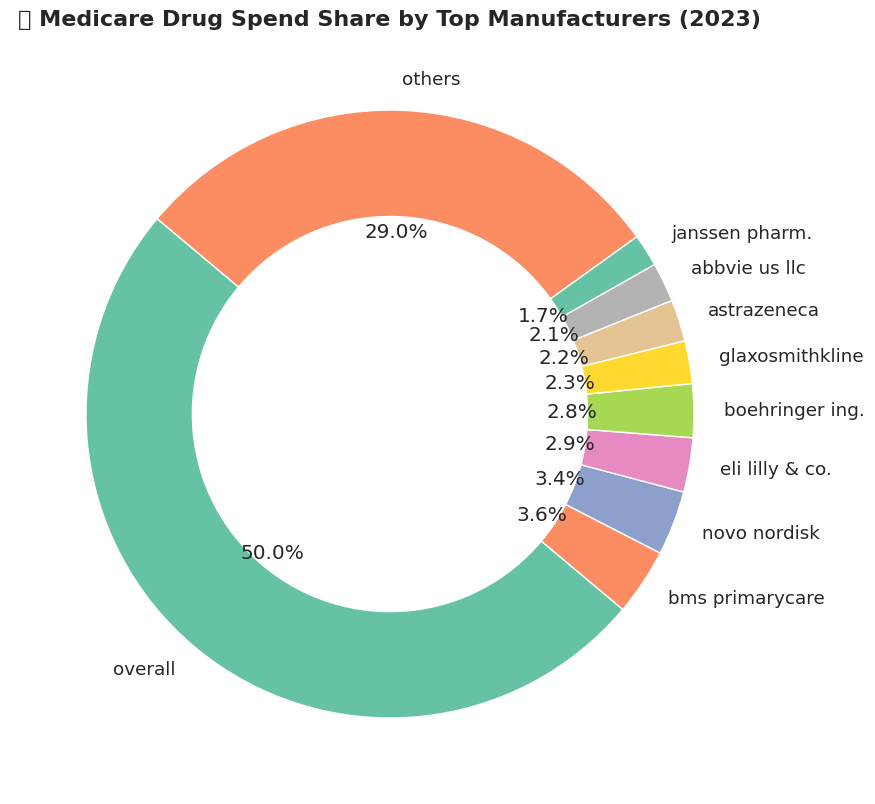

In [26]:
# Manufacturer-Level Spending Share (2023)
top10_mftr = df_long[df_long['year'] == 2023].groupby('mftr_name')['tot_spndng'].sum()
top10 = top10_mftr.nlargest(9)
others = top10_mftr.sum() - top10.sum()
top10['others'] = others

# Plot as donut chart
colors = sns.color_palette('Set2', n_colors=10)
plt.figure(figsize=(9, 9))
plt.pie(top10, labels=top10.index, autopct='%1.1f%%', startangle=140,
        wedgeprops=dict(width=0.35, edgecolor='w'), colors=colors)

plt.title("🏭 Medicare Drug Spend Share by Top Manufacturers (2023)", fontsize=16, weight='bold')
plt.tight_layout()
plt.show()



🧾 What This Pie Chart Shows (Simple Explanation)

- The chart breaks down 2023 Medicare drug spending by manufacturer.

- Each slice shows how much each top manufacturer contributed to the total spend.

- For example, Sanofi-Aventis, Janssen, Novo Nordisk, and Eli Lilly are among the top spenders.

- A large "Others" slice bundles together all the remaining smaller manufacturers.

- The chart helps identify who the key industry players are in terms of cost impact.



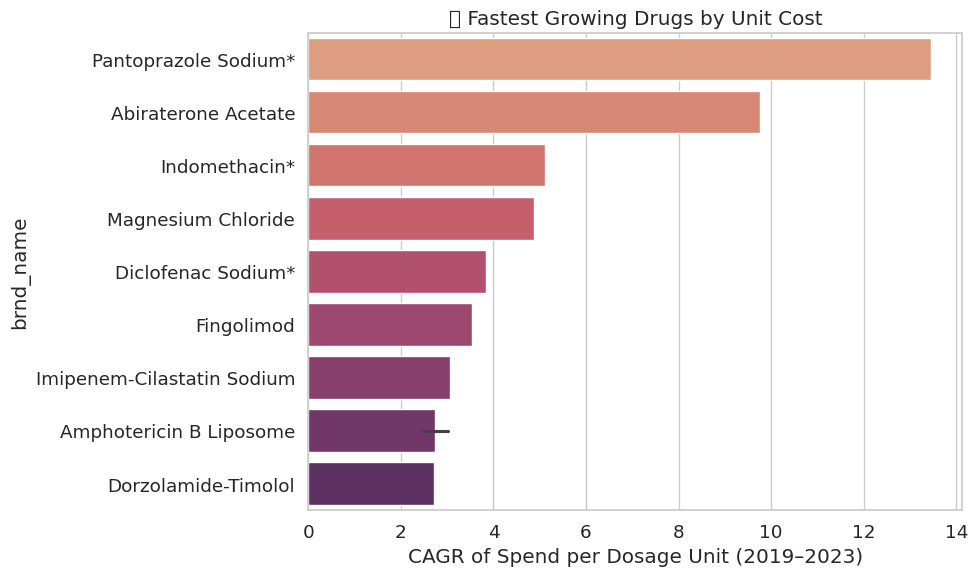

In [27]:
# Detect Outlier Drugs by CAGR (2019–2023)
top_cagr = df_long[df_long['year'] == 2023][['brnd_name', 'cagr_avg_spnd_per_dsg_unt_19_23']] \
            .drop_duplicates().nlargest(10, 'cagr_avg_spnd_per_dsg_unt_19_23')

plt.figure(figsize=(10,6))
sns.barplot(data=top_cagr, x='cagr_avg_spnd_per_dsg_unt_19_23', y='brnd_name', palette='flare')
plt.xlabel('CAGR of Spend per Dosage Unit (2019–2023)')
plt.title('🚀 Fastest Growing Drugs by Unit Cost')
plt.tight_layout()
plt.show()


What This Chart Shows (in Simple Terms)

- Goal: Spot drugs with unusually rapid price growth.

- The x-axis shows the Compound Annual Growth Rate (CAGR) of average spending per dosage unit from 2019 to 2023 higher values mean faster price increases over time.

- Those numbers on the x-axis represent CAGR percentages so 0 means no growth, 6 means the unit cost increased about 6% per year, and so on.

- This bar chart displays the top 10 drugs with the fastest growing unit cost from 2019 to 2023.

- It uses CAGR (Compound Annual Growth Rate) to measure how rapidly the average spend per dosage unit increased for each drug.


- These drugs saw the steepest price acceleration, possibly due to shifts in demand, supply shortages, or formulation changes.

So while other plots showed which drugs cost the most overall, this one reveals which drugs became more expensive the fastest over time useful for tracking emerging cost pressure in Medicare.

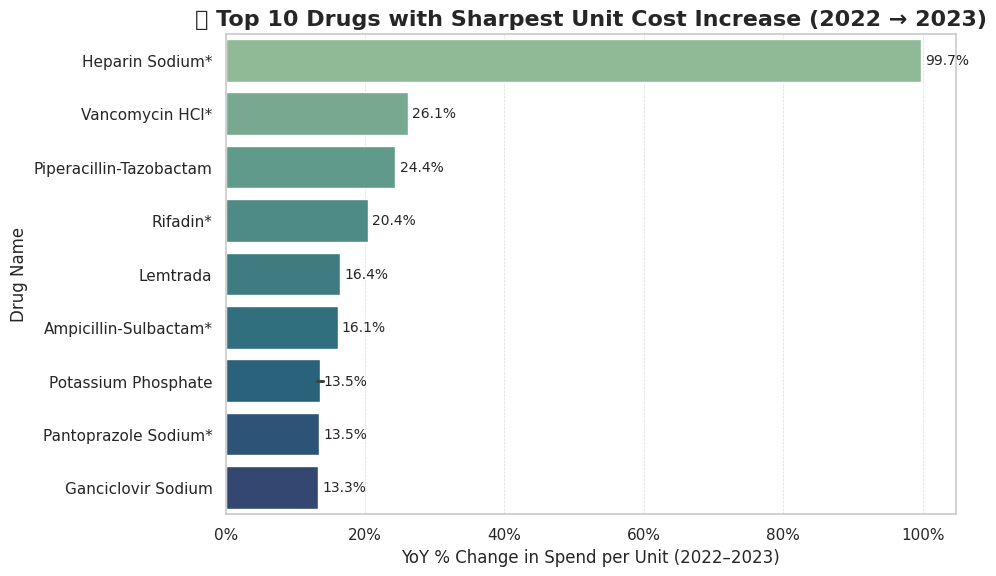

In [28]:
# Year-over-Year Spend Change (2022 → 2023)
# Prepare data
chg = df_long[df_long['year'] == 2023][['brnd_name', 'chg_avg_spnd_per_dsg_unt_22_23']] \
       .drop_duplicates().nlargest(10, 'chg_avg_spnd_per_dsg_unt_22_23')

# Plot
plt.figure(figsize=(10, 6))
bar = sns.barplot(
    data=chg,
    x='chg_avg_spnd_per_dsg_unt_22_23',
    y='brnd_name',
    palette='crest'
)

# Format
plt.title('📈 Top 10 Drugs with Sharpest Unit Cost Increase (2022 → 2023)', fontsize=16, weight='bold')
plt.xlabel('YoY % Change in Spend per Unit (2022–2023)', fontsize=12)
plt.ylabel('Drug Name', fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

# Convert x-axis to percentage format
bar.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=100))

# Add % labels to bars
for container in bar.containers:
    bar.bar_label(container, fmt='%.1f%%', label_type='edge', padding=3, fontsize=10)

plt.grid(axis='x', linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()


What the X-Axis Represents

- The x-axis shows the year-over-year percentage change in average spend per dosage unit from 2022 to 2023.

- Higher values mean faster or steeper price increases for those drugs within that single year.

- Goal: Find recent price shifts that may affect forecasting.

Key Takeaways from the Chart

- The chart highlights the top 10 drugs with the sharpest unit price spikes in 2023 compared to 2022.

- Drugs like Heparin Sodium and Vancomycin HCl saw the biggest jumps, signaling possible price shocks or supply disruptions.

- Many of these drugs are critical hospital-use or infection-related medications—suggesting potential demand surges.

- Such steep changes can significantly impact Medicare budgets and patient affordability in just one year.


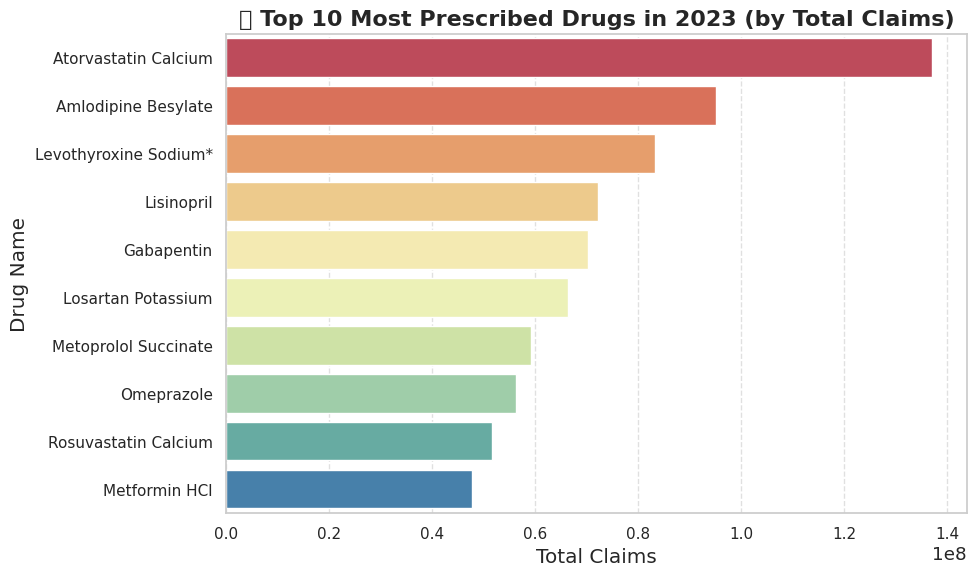

In [29]:
# Top Drugs by Total Claims (2023)  Horizontal Bar Chart
# Get top 10 drugs by total claims in 2023
top_claims = df_long[df_long['year'] == 2023].groupby('brnd_name')['tot_clms'].sum().nlargest(10).reset_index()

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=top_claims, y='brnd_name', x='tot_clms', palette='Spectral')

plt.title('💊 Top 10 Most Prescribed Drugs in 2023 (by Total Claims)', fontsize=16, weight='bold')
plt.xlabel('Total Claims')
plt.ylabel('Drug Name')
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

- X-axis: Shows the total number of prescription claims filed for each drug in 2023

- Each bar reflects how frequently a drug was prescribed, not how expensive it is

Goal of This Chart

- To show which drugs are most used by Medicare patients, helping stakeholders understand demand trends and target areas for cost or supply optimization.

✅ What This Chart Shows (in Simple Terms)

- Lists the Top 10 most prescribed drugs in 2023, ranked by total Medicare claims

- Atorvastatin Calcium is the most prescribed medication, followed by Amlodipine and others

- The chart highlights commonly used chronic medications—often for heart, cholesterol, or blood pressure

- Helps identify high-volume drugs that may have a big impact on public health and forecasting models



# Prepare Data for Modeling

In [30]:
# Ensure df_long is available and sorted
df_long_sorted = df_long.sort_values(["brnd_name", "year"]).reset_index(drop=True)


In [31]:
# Define target
target_col = "tot_spndng"
target_col_log = target_col + "_log"
df_long_sorted[target_col_log] = np.log1p(df_long_sorted[target_col])

#  Feature Engineering

In [32]:
# Lag features
df_long_sorted['spend_lag1'] = df_long_sorted.groupby('brnd_name')[target_col_log].shift(1)
df_long_sorted['spend_lag2'] = df_long_sorted.groupby('brnd_name')[target_col_log].shift(2)


In [33]:
# Rolling mean
df_long_sorted['spend_roll_mean'] = df_long_sorted.groupby('brnd_name')['spend_lag1'].transform(
    lambda x: x.rolling(2, min_periods=1).mean()
)


In [34]:
# YoY change
df_long_sorted['yoy_change'] = df_long_sorted['spend_lag1'] - df_long_sorted['spend_lag2']


In [35]:
# Log-transform dynamic features
dynamic_features = [
    'tot_dsg_unts', 'tot_clms', 'tot_benes',
    'avg_spnd_per_clm', 'avg_spnd_per_bene', 'outlier_flag'
]
for col in dynamic_features:
    df_long_sorted[f"{col}_log"] = np.log1p(df_long_sorted[col])


In [36]:
# Static categorical features
static_features = ['brnd_name', 'gnrc_name', 'mftr_name']  # Don't encode yet

In [37]:
# Define feature columns
feature_columns = [
    'spend_lag1', 'spend_lag2', 'spend_roll_mean', 'yoy_change', 'year', 'tot_mftr'
] + [f"{col}_log" for col in dynamic_features] + [
    'brnd_name', 'gnrc_name', 'mftr_name'
]

In [38]:
# Define categorical columns
categorical_cols = ['brnd_name', 'gnrc_name', 'mftr_name']

In [39]:
# Final dataset
df_model = df_long_sorted[feature_columns + [target_col_log]].copy()
df_model.dropna(inplace=True)

print(f"✅ Final dataset shape: {df_model.shape}")


✅ Final dataset shape: (64597, 16)


# Time-Aware Train-Validation Split

In [40]:
train = df_model[df_model['year'] < 2023]
val = df_model[df_model['year'] == 2023]

X_train = train.drop(columns=[target_col_log])
y_train = train[target_col_log]
X_val = val.drop(columns=[target_col_log])
y_val = val[target_col_log]



In [41]:
# Set categorical columns
categorical_cols = ['brnd_name', 'gnrc_name', 'mftr_name']
for col in categorical_cols:
    X_train[col] = X_train[col].astype('category')
    X_val[col] = X_val[col].astype('category')

print(f"Train size: {X_train.shape}, Val size: {X_val.shape}")

Train size: (50288, 15), Val size: (14309, 15)


# Optuna Hyperparameter tuning with LightGBM

In [42]:
# -------------------------------

def objective(trial: Trial):
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'num_leaves': trial.suggest_int('num_leaves', 10, 200),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),
        'random_state': 42,
        'verbose': -1
    }

    # Create dataset
    train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_cols)
    val_data = lgb.Dataset(X_val, label=y_val, categorical_feature=categorical_cols, reference=train_data)

    # Train with early stopping
    model = lgb.train(
        params,
        train_data,
        valid_sets=[train_data, val_data],
        valid_names=['train', 'val'],
        callbacks=[
            lgb.early_stopping(stopping_rounds=20, verbose=False),
            lgb.log_evaluation(period=0)
        ]
    )

    # Predict and evaluate
    preds = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, preds))
    return rmse

In [43]:
# Run Optuna
print("Starting Optuna hyperparameter tuning...")
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30, show_progress_bar=True)



[I 2025-07-30 11:41:11,193] A new study created in memory with name: no-name-516bb487-9914-4e85-9235-c90c905d33c5


Starting Optuna hyperparameter tuning...


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-07-30 11:41:14,389] Trial 0 finished with value: 0.1991831553478432 and parameters: {'n_estimators': 225, 'learning_rate': 0.1301746655344672, 'max_depth': 5, 'num_leaves': 173, 'subsample': 0.8635071888788011, 'colsample_bytree': 0.8697369099852046, 'reg_alpha': 5.698231027032497, 'reg_lambda': 1.605198387693314}. Best is trial 0 with value: 0.1991831553478432.
[I 2025-07-30 11:41:16,177] Trial 1 finished with value: 0.43309181840901284 and parameters: {'n_estimators': 140, 'learning_rate': 0.24103411369715444, 'max_depth': 7, 'num_leaves': 187, 'subsample': 0.7120128945328238, 'colsample_bytree': 0.7870572878772508, 'reg_alpha': 3.0745992929929034, 'reg_lambda': 9.56513318696015}. Best is trial 0 with value: 0.1991831553478432.
[I 2025-07-30 11:41:18,555] Trial 2 finished with value: 0.22180187546124003 and parameters: {'n_estimators': 282, 'learning_rate': 0.18821475086930844, 'max_depth': 5, 'num_leaves': 79, 'subsample': 0.6546105682448602, 'colsample_bytree': 0.9563122462

In [44]:
print(f"Best RMSE: {study.best_value:.4f}")
print(f"Best params: {study.best_params}")

Best RMSE: 0.1044
Best params: {'n_estimators': 137, 'learning_rate': 0.14517348521934195, 'max_depth': 11, 'num_leaves': 74, 'subsample': 0.6761068653461081, 'colsample_bytree': 0.9761256987209621, 'reg_alpha': 4.3706990048896746, 'reg_lambda': 1.797704801048547}


# Train Final Model

In [45]:
# -------------------------------

best_params = study.best_params
best_params.update({
    'objective': 'regression',
    'metric': 'rmse',
    'verbose': -1,
    'random_state': 42
})

train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_cols)
val_data = lgb.Dataset(X_val, label=y_val, categorical_feature=categorical_cols)

final_model = lgb.train(
    best_params,
    train_data,
    valid_sets=[train_data, val_data],
    callbacks=[lgb.early_stopping(stopping_rounds=20), lgb.log_evaluation(10)]
)

# -------------------------------

Training until validation scores don't improve for 20 rounds
[10]	training's rmse: 0.660199	valid_1's rmse: 0.801793
[20]	training's rmse: 0.18545	valid_1's rmse: 0.236271
[30]	training's rmse: 0.101574	valid_1's rmse: 0.135225
[40]	training's rmse: 0.08507	valid_1's rmse: 0.11802
[50]	training's rmse: 0.0794049	valid_1's rmse: 0.113492
[60]	training's rmse: 0.0765511	valid_1's rmse: 0.111467
[70]	training's rmse: 0.0744231	valid_1's rmse: 0.10997
[80]	training's rmse: 0.0726371	valid_1's rmse: 0.108746
[90]	training's rmse: 0.0709292	valid_1's rmse: 0.107427
[100]	training's rmse: 0.0695748	valid_1's rmse: 0.106614
[110]	training's rmse: 0.0684075	valid_1's rmse: 0.106
[120]	training's rmse: 0.0672332	valid_1's rmse: 0.105154
[130]	training's rmse: 0.066285	valid_1's rmse: 0.104564
Did not meet early stopping. Best iteration is:
[137]	training's rmse: 0.0657017	valid_1's rmse: 0.104381


#  Evaluate

In [46]:
#  Evaluate
# -------------------------------

preds = final_model.predict(X_val)
y_val_orig = np.expm1(y_val)
preds_orig = np.expm1(preds)

mae = mean_absolute_error(y_val_orig, preds_orig)
rmse = np.sqrt(mean_squared_error(y_val_orig, preds_orig))
mape = mean_absolute_percentage_error(y_val_orig, preds_orig)

print(f"✅ Final Evaluation (Original Scale):")
print(f"MAE:  ${mae:,.2f}")
print(f"RMSE: ${rmse:,.2f}")
print(f"MAPE: {mape:.2%}")

✅ Final Evaluation (Original Scale):
MAE:  $7,074,332.64
RMSE: $150,513,848.00
MAPE: 6.95%


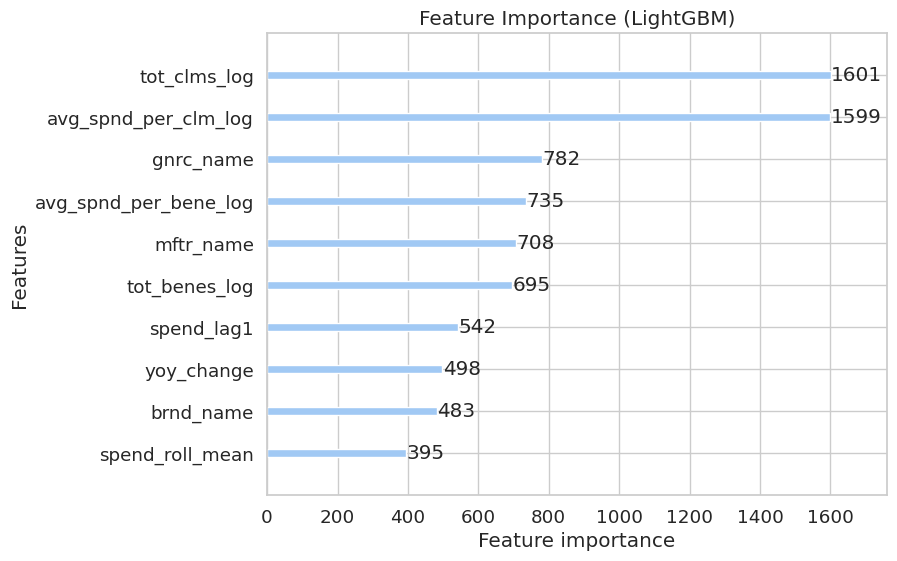

In [47]:
# Feature importance
lgb.plot_importance(final_model, max_num_features=10, figsize=(8, 6))
plt.title("Feature Importance (LightGBM)")
plt.show()

#  Save Model

In [48]:
# -------------------------------
# STEP 11: Save Model & Metadata (With Reusable Pipeline)
# -------------------------------

# Wrap the model and preprocessing into a single reusable class
class DrugSpendingPredictor:
    def __init__(self, model, feature_cols, cat_cols, target_log_col):
        self.model = model
        self.feature_cols = feature_cols
        self.cat_cols = cat_cols
        self.target_log_col = target_log_col

    def predict(self, df):
        """Predict total spending on new data. Expects raw df_long-style DataFrame."""
        # Sort for consistency
        df = df.sort_values(['brnd_name', 'year']).copy()

        # Recreate features
        target_col = "tot_spndng"
        df[f"{target_col}_log"] = np.log1p(df[target_col])

        # Lag features
        df['spend_lag1'] = df.groupby('brnd_name')[f"{target_col}_log"].shift(1)
        df['spend_lag2'] = df.groupby('brnd_name')[f"{target_col}_log"].shift(2)

        # Rolling mean
        df['spend_roll_mean'] = df.groupby('brnd_name')['spend_lag1'].transform(
            lambda x: x.rolling(2, min_periods=1).mean()
        )

        # YoY change
        df['yoy_change'] = df['spend_lag1'] - df['spend_lag2']

        # Log-transform dynamic features
        dynamic_features = [
            'tot_dsg_unts', 'tot_clms', 'tot_benes',
            'avg_spnd_per_clm', 'avg_spnd_per_bene', 'outlier_flag'
        ]
        for col in dynamic_features:
            df[f"{col}_log"] = np.log1p(df[col])

        # Prepare feature matrix
        X = df[self.feature_cols].copy()
        for col in self.cat_cols:
            X[col] = X[col].astype('category')

        # Predict in log space and reverse transform
        log_pred = self.model.predict(X)
        return np.expm1(log_pred)

# Instantiate and save the full predictor
predictor = DrugSpendingPredictor(
    model=final_model,
    feature_cols=feature_columns,
    cat_cols=categorical_cols,
    target_log_col=target_col_log
)

# Save predictor object
joblib.dump(predictor, 'drug_spending_predictor.pkl')

# Save metadata for reference
metadata = {
    'feature_columns': feature_columns,
    'categorical_columns': categorical_cols,
    'target_column': target_col_log,
    'model_type': 'LightGBM',
    'training_years': [2019, 2020, 2021, 2022],
    'forecast_target_year': 2023,
    'version': '1.0',
    'created_on': pd.Timestamp.now().strftime("%Y-%m-%d")
}
joblib.dump(metadata, 'model_metadata.pkl')

print("✅ Model and metadata saved: drug_spending_predictor.pkl, model_metadata.pkl")




✅ Model and metadata saved: drug_spending_predictor.pkl, model_metadata.pkl


# Forecast 2024

In [49]:
# Forecast 2024
# -------------------------------

# Use 2023 as base year and shift to 2024
forecast_base = df_long[df_long['year'] == 2023].copy()
forecast_base['year'] = 2024  # Predict for 2024

# Generate forecasts
forecasts_2024 = predictor.predict(forecast_base)

# Create results DataFrame
forecast_results = pd.DataFrame({
    'brnd_name': forecast_base['brnd_name'].values,
    'manufacturer': forecast_base['mftr_name'].values,
    'forecast_2024_total_spending': forecasts_2024
}).nlargest(10, 'forecast_2024_total_spending').reset_index(drop=True)

print("📈 Top 10 Forecasted Drugs for 2024:")
print(forecast_results)

📈 Top 10 Forecasted Drugs for 2024:
         brnd_name     manufacturer  forecast_2024_total_spending
0          Eliquis  bms primarycare                  3.156828e+09
1          Ozempic     novo nordisk                  2.828201e+09
2        Jardiance  boehringer ing.                  2.776480e+09
3          Xarelto   janssen pharm.                  2.512456e+09
4        Trulicity  eli lilly & co.                  2.223999e+09
5  Trelegy Ellipta  glaxosmithkline                  2.030497e+09
6          Januvia  merck sharp & d                  1.806726e+09
7         Revlimid      celgene/bms                  1.776255e+09
8  Novolog Flexpen     novo nordisk                  1.767898e+09
9          Farxiga      astrazeneca                  1.758347e+09


In [50]:
# Save to CSV
forecast_results.to_csv('top_10_drug_forecasts_2024.csv', index=False)
print("✅ Forecast results saved to 'top_10_drug_forecasts_2024.csv'")

✅ Forecast results saved to 'top_10_drug_forecasts_2024.csv'


# CREATE MODULES

In [51]:
# CREATE MODULES
# -------------------------------

# Make directories
os.makedirs("src", exist_ok=True)
os.makedirs("models", exist_ok=True)
os.makedirs("data/processed", exist_ok=True)

# 1. src/ingest.py
with open("src/ingest.py", "w") as f:
    f.write('''
def load_data(file_path):
    """Load raw CMS data."""
    import pandas as pd
    df = pd.read_csv(file_path)
    print(f"✅ Data loaded: {df.shape}")
    return df
''')

# 2. src/preprocess.py
with open("src/preprocess.py", "w") as f:
    f.write('''
def clean_data(df):
    """Clean and standardize column names and values."""
    df.columns = (df.columns
                  .str.strip()
                  .str.lower()
                  .str.replace(' ', '_', regex=False)
                  .str.replace('-', '_', regex=False))
    df['mftr_name'] = (df['mftr_name']
                       .str.strip()
                       .str.lower()
                       .str.replace(r'\\s+', ' ', regex=True))
    return df

def reshape_to_long(df):
    """Reshape from wide to long format."""
    import pandas as pd
    id_vars = ['brnd_name', 'gnrc_name', 'tot_mftr', 'mftr_name']
    value_vars = [col for col in df.columns if any(str(yr) in col for yr in range(2019, 2024))]

    df_long = pd.wide_to_long(
        df,
        stubnames=[
            'tot_spndng', 'tot_dsg_unts', 'tot_clms', 'tot_benes',
            'avg_spnd_per_dsg_unt_wghtd', 'avg_spnd_per_clm', 'avg_spnd_per_bene', 'outlier_flag'
        ],
        i=id_vars,
        j='year',
        sep='_',
        suffix=r'\\d+'
    ).reset_index()
    return df_long
''')

# 3. src/features.py
with open("src/features.py", "w") as f:
    f.write('''
def create_features(df):
    """Add lag, rolling, and log features."""
    import numpy as np
    df = df.sort_values(['brnd_name', 'year']).copy()
    df['tot_spndng_log'] = np.log1p(df['tot_spndng'])

    df['spend_lag1'] = df.groupby('brnd_name')['tot_spndng_log'].shift(1)
    df['spend_lag2'] = df.groupby('brnd_name')['tot_spndng_log'].shift(2)
    df['spend_roll_mean'] = df.groupby('brnd_name')['spend_lag1'].transform(
        lambda x: x.rolling(2, min_periods=1).mean()
    )
    df['yoy_change'] = df['spend_lag1'] - df['spend_lag2']

    dynamic_features = [
        'tot_dsg_unts', 'tot_clms', 'tot_benes',
        'avg_spnd_per_clm', 'avg_spnd_per_bene', 'outlier_flag'
    ]
    for col in dynamic_features:
        df[f"{col}_log"] = np.log1p(df[col])

    return df
''')

# 4. src/model.py
with open("src/model.py", "w") as f:
    f.write('''
def train_and_save_model(df, feature_columns, categorical_cols, target_col_log):
    """Train LightGBM model and save with metadata."""
    from sklearn.model_selection import train_test_split
    import lightgbm as lgb
    import joblib

    train = df[df['year'] < 2023]
    val = df[df['year'] == 2023]

    X_train = train[feature_columns + categorical_cols]
    y_train = train[target_col_log]
    X_val = val[feature_columns + categorical_cols]
    y_val = val[target_col_log]

    for col in categorical_cols:
        X_train[col] = X_train[col].astype('category')
        X_val[col] = X_val[col].astype('category')

    train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_cols)
    val_data = lgb.Dataset(X_val, label=y_val, categorical_feature=categorical_cols)

    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'num_leaves': 31,
        'learning_rate': 0.05,
        'feature_fraction': 0.9,
        'verbose': -1
    }

    model = lgb.train(
        params,
        train_data,
        valid_sets=[train_data, val_data],
        callbacks=[lgb.early_stopping(20), lgb.log_evaluation(10)]
    )

    joblib.dump(model, '../models/final_model.pkl')
    print("✅ Model trained and saved.")
    return model
''')

print("📁 Modular structure created: src/ingest.py, preprocess.py, features.py, model.py")

📁 Modular structure created: src/ingest.py, preprocess.py, features.py, model.py


#  Package Project for GitHub & Deployment

In [52]:
# -------------------------------
#  Package Project for GitHub & Deployment
# -------------------------------
# Ensure directories exist
os.makedirs("medicare_forecast/src", exist_ok=True)
os.makedirs("medicare_forecast/models", exist_ok=True)
os.makedirs("medicare_forecast/data/processed", exist_ok=True)

In [53]:
#  Move modular .py files
!mv src/*.py medicare_forecast/src/ 2>/dev/null || echo "No src/*.py files to move"


In [54]:
# Copy saved model & metadata
!cp drug_spending_predictor.pkl medicare_forecast/models/
!cp model_metadata.pkl medicare_forecast/models/


In [55]:
#  Copy forecast results
!cp top_10_drug_forecasts_2024.csv medicare_forecast/data/processed/


In [57]:
# 5. Create requirements.txt with EXACT versions (Critical!)
# This ensures no version conflicts during deployment

# Get installed versions
# !pip freeze > medicare_forecast/requirements.txt  # Full list

# Or, use curated list with key packages only:
with open("medicare_forecast/requirements.txt", "w") as f:
    f.write("pandas\n")
    f.write("numpy\n")
    f.write("matplotlib\n")
    f.write("seaborn\n")
    f.write("lightgbm\n")
    f.write("optuna\n")
    f.write("joblib\n")
    f.write("scikit-learn\n")
    f.write("xgboost\n")
    f.write("shap\n")
    f.write("plotly\n")
    f.write("streamlit\n")
    f.write("fastapi\n")
    f.write("uvicorn\n")
    f.write("requests\n")
    f.write("python-dotenv\n")

print("✅ requirements.txt created (minimal dependencies)")



✅ requirements.txt created (minimal dependencies)


In [58]:
# 6. Create README.md
with open("medicare_forecast/README.md", "w") as f:
    f.write("# Medicare Part D Drug Spending Forecasting Tool\n\n")
    f.write("AI-powered forecasting system for Medicare Part D drug spending using LightGBM + Optuna.\n\n")
    f.write("## Features\n")
    f.write("- EDA on CMS data (2019–2023)\n")
    f.write("- Feature engineering with lags & rolling stats\n")
    f.write("- Forecasting with reusable `DrugSpendingPredictor`\n")
    f.write("- Top 10 drug forecast for 2024\n\n")
    f.write("## Setup\n")
    f.write("```bash\n")
    f.write("pip install -r requirements.txt\n")
    f.write("```\n")

print("✅ README.md created")


✅ README.md created


In [59]:
#  ZIP the folder
!zip -r medicare_forecast.zip medicare_forecast/


  adding: medicare_forecast/ (stored 0%)
  adding: medicare_forecast/src/ (stored 0%)
  adding: medicare_forecast/src/features.py (deflated 56%)
  adding: medicare_forecast/src/preprocess.py (deflated 59%)
  adding: medicare_forecast/src/ingest.py (deflated 21%)
  adding: medicare_forecast/src/model.py (deflated 57%)
  adding: medicare_forecast/models/ (stored 0%)
  adding: medicare_forecast/models/drug_spending_predictor.pkl (deflated 66%)
  adding: medicare_forecast/models/model_metadata.pkl (deflated 34%)
  adding: medicare_forecast/README.md (deflated 33%)
  adding: medicare_forecast/requirements.txt (deflated 26%)
  adding: medicare_forecast/data/ (stored 0%)
  adding: medicare_forecast/data/processed/ (stored 0%)
  adding: medicare_forecast/data/processed/top_10_drug_forecasts_2024.csv (deflated 27%)


In [60]:
# 8. Download ZIP
from google.colab import files
files.download('medicare_forecast.zip')

print(" Project packaged and ready! Upload medicare_forecast.zip to GitHub.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 Project packaged and ready! Upload medicare_forecast.zip to GitHub.


In [62]:
# -------------------------------
# CHECK VERSIONS FOR DEPLOYMENT
# -------------------------------
import sys
import pandas as pd
import numpy as np
import sklearn
import lightgbm as lgb
import optuna
import matplotlib
import seaborn as sns
import joblib

print("Python Version:", sys.version)
print("pandas:", pd.__version__)
print("numpy:", np.__version__)
print("scikit-learn:", sklearn.__version__)
print("lightgbm:", lgb.__version__)
print("optuna:", optuna.__version__)
print("matplotlib:", matplotlib.__version__)
print(" seaborn:", sns.__version__)
print("joblib:", joblib.__version__)


Python Version: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
pandas: 2.2.2
numpy: 2.0.2
scikit-learn: 1.6.1
lightgbm: 4.6.0
optuna: 4.4.0
matplotlib: 3.10.0
 seaborn: 0.13.2
joblib: 1.5.1
